In [67]:
import cello_multiplier as cm
from onto_lib import general_ontology_tools as got
import pandas as pd


In [68]:
B_df, Z_df, labels, per_gene_mean, per_gene_std, train_dummies_specific, train_dummies_full = cm.get_default_mats()

In [69]:
#split 
from pathlib import Path
import json

split_dir = Path('split')



with open(split_dir / 'validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open(split_dir / 'pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [70]:
train_Y_df = B_df[B_df.index.isin(train_egs)]
train_Y_df.shape



(3609, 258)

In [71]:
test_Y_df = B_df[B_df.index.isin(validation_egs)]
test_Y_df.shape

(684, 258)

In [72]:
# create list of samples by celltypes
from sklearn.preprocessing import MultiLabelBinarizer

sample2types = {
            sample: list(map(got.get_term_name, types_ids))
            for sample, types_ids in labels.items()
        }

types_per_b_samples = B_df.index.map(sample2types).values

mlb = MultiLabelBinarizer()
types_per_b_samples = B_df.index.map(sample2types).values

samples_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_df.index)

celltypes = samples_dummies.columns.tolist()

type2samples = {
    type_: samples_dummies.index[samples_dummies[type_] == 1].tolist()
    for type_ in celltypes
}

In [73]:
# create target list for given cell type with 1 being that cell type and 0 being any other cell type
def set_target(celltype, type2samples, train_Y_df, test_Y_df, oversample, max_neg_pos_ratio):
    samplelist = type2samples[celltype]
    samplelist_train = [x for x in samplelist if x in train_Y_df.index.values]
    samplelist_test = [x for x in samplelist if x in test_Y_df.index.values]
    
    if(oversample == True and len(samplelist_train) > 0 and len(samplelist_test) >0):
        len_negative_train = len(train_Y_df)-len(samplelist_train)
        len_positive_train = len(samplelist_train)
        
        neg_pos_ratio = len_negative_train / len_positive_train
        
        # limit the max oversampling ratio
        neg_pos_ratio = min(neg_pos_ratio, max_neg_pos_ratio)
        
        if(neg_pos_ratio > 1):
            df_train = train_Y_df.loc[samplelist_train].sample(
                    n=int((neg_pos_ratio - 1) * len_positive_train),
                    replace=True, random_state=111
                )
            train_Y_df = train_Y_df.append(df_train)
    
    target_train = pd.Series(0,index = train_Y_df.index)
    target_train.loc[samplelist_train] = 1
    
    target_test = pd.Series(0,index = test_Y_df.index)
    target_test.loc[samplelist_test] = 1
    
    #train_Y_transformed = scaler.transform(train_Y_df)
    #test_Y_transformed = scaler.transform(test_Y_df)
    
    return(target_train.values, target_test.values, train_Y_df, test_Y_df )

In [74]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(B_df)

In [75]:
def fscore(p, r):
    denom = p + r or 1

    return (p * r) / denom

In [76]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
import numpy as np
import warnings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [77]:
#types_with_data = types_sizes[types_sizes > 50].index.values
all_types = samples_dummies.columns

In [78]:
warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

successful_celltypes = []
unsuccessful_celltypes = []
test_prs = []
test_precision = []
test_recall = []
fscores = []

for cell_type in tqdm(all_types):
    train_target, train_test, train_data, test_data = set_target(
        cell_type, type2samples, train_Y_df, test_Y_df, oversample=True,
        max_neg_pos_ratio=2
    )
    
    if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
        # lasso penalty
        clf = LogisticRegression(solver = "lbfgs",penalty = "l2",random_state=111 )
        
        clf.fit(train_data, train_target)
        target_pred = clf.predict(test_data)
        test_pr = metrics.average_precision_score(train_test, target_pred)
        test_precision += [precision_score(train_test, target_pred)]
        test_recall += [recall_score(train_test, target_pred)]
        fscores += [fscore(test_precision[-1], test_recall[-1])]
        successful_celltypes += [cell_type]
        #plot precision recall curve for celltype
#         disp = plot_precision_recall_curve(clf, test_data, train_test)
#         disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
    else:
        unsuccessful_celltypes += [cell_type]
        
p = np.mean(test_precision)
r = np.mean(test_recall)
f = np.mean(fscores)
f_micro = fscore(p, r) 

report = pd.DataFrame(list(zip(successful_celltypes,test_precision,test_recall, fscores)),
                      columns = ["celltype","precision score","recall score","f score"])


In [79]:
print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}')

precision: 0.5988, recall: 0.4867, f1: 0.2501, f1 micro avg: 0.2685


In [80]:
report

,celltype,precision score,recall score,f score
0,B cell,1.000000,0.684211,0.406250
1,CD14-positive monocyte,0.685714,0.857143,0.380952
2,"CD14-positive, CD16-negative classical monocyte",0.000000,0.000000,0.000000
3,CD141-positive myeloid dendritic cell,0.000000,0.000000,0.000000
4,CD1c-positive myeloid dendritic cell,1.000000,0.750000,0.428571
...,...,...,...,...
204,type B pancreatic cell,1.000000,1.000000,0.500000
205,type II pneumocyte,0.000000,0.000000,0.000000
206,vascular associated smooth muscle cell,0.000000,0.000000,0.000000
207,vein endothelial cell,0.750000,1.000000,0.428571


In [81]:
warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

solvers = ["newton-cg", "lbfgs","sag", "saga"]
ps = []
rs = []
fs = []
fms = []
for solver in  tqdm(solvers):
    successful_celltypes = []
    unsuccessful_celltypes = []
    test_prs = []
    test_precision = []
    test_recall = []
    fscores = []


    for cell_type in tqdm(all_types):
        train_target, train_test, train_data, test_data = set_target(
            cell_type, type2samples, train_Y_df, test_Y_df, oversample=True,
            max_neg_pos_ratio=2
        )

        if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
            # lasso penalty
            clf = LogisticRegression(solver = solver,penalty = "l2",random_state=111 )

            clf.fit(train_data, train_target)
            target_pred = clf.predict(test_data)
            test_pr = metrics.average_precision_score(train_test, target_pred)
            test_precision += [precision_score(train_test, target_pred)]
            test_recall += [recall_score(train_test, target_pred)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]
            successful_celltypes += [cell_type]
            #plot precision recall curve for celltype
    #         disp = plot_precision_recall_curve(clf, test_data, train_test)
    #         disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
        else:
            unsuccessful_celltypes += [cell_type]

    p = np.mean(test_precision)
    r = np.mean(test_recall)
    f = np.mean(fscores)
    
    print(len(test_precision))
    print(len(test_recall))
    
    f_micro = fscore(p, r) 
    ps += [p]
    rs += [r]
    fs += [f]
    fms += [f_micro]
report = pd.DataFrame(list(zip(ps,rs,fs,fms)), index = solvers, columns = ["precision_avg","recall_avg","fscore_avg","fmicro_avg"])


209
209



209
209



209
209



209
209



In [82]:
report.sort_values(by="fmicro_avg",ascending = False)

,precision_avg,recall_avg,fscore_avg,fmicro_avg
saga,0.608422,0.487598,0.250962,0.270675
newton-cg,0.598850,0.486689,0.250142,0.268487
lbfgs,0.598850,0.486689,0.250142,0.268487
sag,0.598709,0.486290,0.250026,0.268338


In [83]:
warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

solvers = ["liblinear", "saga"]
ps = []
rs = []
fs = []
fms = []
for solver in  tqdm(solvers):
    successful_celltypes = []
    unsuccessful_celltypes = []
    test_prs = []
    test_precision = []
    test_recall = []
    fscores = []


    for cell_type in tqdm(all_types):
        train_target, train_test, train_data, test_data = set_target(
            cell_type, type2samples, train_Y_df, test_Y_df, oversample=True,
            max_neg_pos_ratio=2
        )

        if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
            # lasso penalty
            clf = LogisticRegression(solver = solver,penalty = "l1",random_state=111 )

            clf.fit(train_data, train_target)
            target_pred = clf.predict(test_data)
            test_pr = metrics.average_precision_score(train_test, target_pred)
            test_precision += [precision_score(train_test, target_pred)]
            test_recall += [recall_score(train_test, target_pred)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]
            successful_celltypes += [cell_type]
            #plot precision recall curve for celltype
    #         disp = plot_precision_recall_curve(clf, test_data, train_test)
    #         disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
        else:
            unsuccessful_celltypes += [cell_type]

    p = np.mean(test_precision)
    r = np.mean(test_recall)
    f = np.mean(fscores)
    f_micro = fscore(p, r) 
    print(len(test_precision))
    print(len(test_recall))
    ps += [p]
    rs += [r]
    fs += [f]
    fms += [f_micro]
report = pd.DataFrame(list(zip(ps,rs,fs,fms)), index = solvers, columns = ["precision_avg","recall_avg","fscore_avg","fmicro_avg"])


209
209



209
209



In [84]:
report.sort_values(by="fmicro_avg",ascending = False)

,precision_avg,recall_avg,fscore_avg,fmicro_avg
liblinear,0.634797,0.516961,0.262905,0.284926
saga,0.613721,0.512993,0.262752,0.279427


In [85]:
warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning


ps = []
rs = []
fs = []
fms = []
classifiers ={}

successful_celltypes = []
unsuccessful_celltypes = []
test_prs = []
test_precision = []
test_recall = []
fscores = []


for cell_type in tqdm(all_types):
        train_target, train_test, train_data, test_data = set_target(
            cell_type, type2samples, train_Y_df, test_Y_df, oversample=True,
            max_neg_pos_ratio=2
        )

        if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
            # lasso penalty
            classifiers[cell_type] = LogisticRegression(solver = "liblinear",penalty = "l1",random_state=111 )

            classifiers[cell_type].fit(train_data, train_target)
            target_pred = classifiers[cell_type].predict(test_data)
            test_pr = metrics.average_precision_score(train_test, target_pred)
            test_precision += [precision_score(train_test, target_pred)]
            test_recall += [recall_score(train_test, target_pred)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]
            successful_celltypes += [cell_type]
            #plot precision recall curve for celltype
    #         disp = plot_precision_recall_curve(clf, test_data, train_test)
    #         disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
        else:
            unsuccessful_celltypes += [cell_type]

p = np.mean(test_precision)
r = np.mean(test_recall)
f = np.mean(fscores)
f_micro = fscore(p, r) 
print(len(test_precision))
print(len(test_recall))
   
report = pd.DataFrame(list(zip(test_precision,test_recall,fscores)),index = successful_celltypes, columns = ["precision_avg","recall_avg","fscore_avg"])


209
209


In [132]:
report

,precision_avg,recall_avg,fscore_avg
B cell,0.764706,0.684211,0.361111
CD14-positive monocyte,0.724138,0.750000,0.368421
"CD14-positive, CD16-negative classical monocyte",0.000000,0.000000,0.000000
CD141-positive myeloid dendritic cell,0.000000,0.000000,0.000000
CD1c-positive myeloid dendritic cell,1.000000,0.583333,0.368421
...,...,...,...
type B pancreatic cell,0.666667,1.000000,0.400000
type II pneumocyte,0.000000,0.000000,0.000000
vascular associated smooth muscle cell,0.000000,0.000000,0.000000
vein endothelial cell,0.750000,1.000000,0.428571


In [88]:
report1 = report[report["fscore_avg"]>0]

In [89]:
report1.sort_values(by="fscore_avg", ascending = False)

,precision_avg,recall_avg,fscore_avg
metabolising cell,1.0,1.000000,0.500000
serotonin secreting cell,1.0,1.000000,0.500000
mammary gland epithelial cell,1.0,1.000000,0.500000
primordial germ cell,1.0,1.000000,0.500000
polyploid cell,1.0,1.000000,0.500000
...,...,...,...
electrically signaling cell,1.0,0.017544,0.017241
central nervous system neuron,1.0,0.017544,0.017241
neuron,1.0,0.017544,0.017241
electrically active cell,1.0,0.016667,0.016393


array([[<AxesSubplot:title={'center':'fscore_avg'}>]], dtype=object)

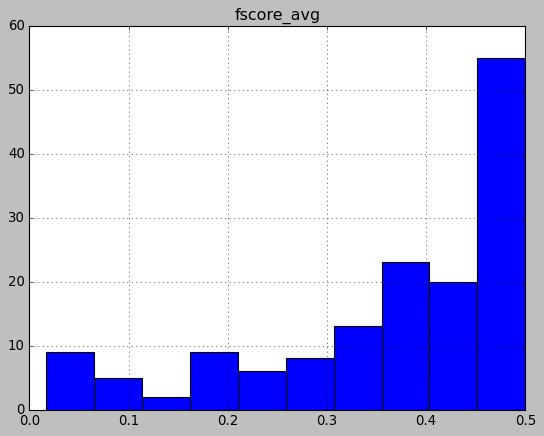

In [90]:
import matplotlib.pyplot as plt
plt.style.use('classic')
report1.hist("fscore_avg",bins=10)

In [91]:
celltypes = report1.index.values

for celltype in celltypes:
    clf = classifiers[celltype]
    params = clf.coef_
    print(params)

[[ 0.          0.          0.         -0.20451704  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         10.57295153  0.          0.
   0.          0.          0.         -3.25318522  0.          0.
   2.76243111  0.          0.          0.          0.          0.
   0.          0.88590323  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          3.35274352  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.51903344  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.     

In [92]:
test_Y_df

,"1,REACTOME_TRNA_AMINOACYLATION","2,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION","3,REACTOME_SIGNALING_BY_GPCR","4,REACTOME_INNATE_IMMUNE_SYSTEM","5,KEGG_HEMATOPOIETIC_CELL_LINEAGE","6,REACTOME_TRANSMEMBRANE_TRANSPORT_OF_SMALL_MOLECULES",LV 7,"8,KEGG_RIBOSOME","9,KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION","10,REACTOME_DEVELOPMENTAL_BIOLOGY",...,"249,REACTOME_SIGNALING_BY_GPCR","250,REACTOME_GPCR_DOWNSTREAM_SIGNALING",LV 251,"252,REACTOME_GPCR_LIGAND_BINDING",LV 253,"254,REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS",LV 255,"256,KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION",LV 257,"258,KEGG_LYSOSOME"
SRX1037440,-0.478183,0.031681,0.161143,-0.106367,0.156281,0.005344,0.034554,-0.159232,-0.069372,0.169316,...,0.145190,-0.027307,0.009672,0.060933,0.120692,-0.014299,0.088332,0.148214,0.067434,-0.469485
SRX1433442,-0.110069,-0.113076,-0.158124,0.923680,-0.716442,-0.052939,-0.015547,0.038644,0.080532,0.047620,...,-0.044679,-0.008153,0.066509,-0.147358,0.052937,-0.012748,-0.029487,-0.100887,-0.032992,-0.005234
SRX1433443,-0.388263,-0.086000,0.000905,0.718151,-0.596955,-0.002493,-0.024926,0.080121,0.050156,-0.057794,...,0.037869,0.048802,0.047634,-0.168902,0.162406,0.088884,0.042916,-0.098409,-0.097540,0.065171
SRX1433441,-0.035499,-0.061733,-0.104566,0.954174,-0.653590,-0.127065,0.086374,0.191797,0.156774,0.067797,...,-0.013459,0.035884,0.097322,-0.155224,-0.102832,-0.040409,0.026348,-0.004794,0.068869,0.025518
SRX2433589,0.398788,0.065452,-0.237951,0.237805,-0.428983,0.162307,0.005535,-0.170391,0.249692,-0.031583,...,-0.267033,-0.026375,-0.214073,-0.303336,-0.222614,0.217533,0.030655,0.012749,0.177243,0.394292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX1733703,0.040411,0.043889,-0.023448,-0.143341,0.347298,-0.350452,-0.149163,-0.467751,-0.152684,0.169815,...,0.240210,-0.012784,0.000666,-0.069582,0.066554,0.282204,0.092185,0.021339,0.148489,0.223935
SRX1733704,0.065336,0.353445,-0.209785,-0.131981,0.366370,-0.228532,0.174834,-0.489593,-0.252474,0.153338,...,0.080369,0.045497,-0.086159,0.090056,0.038143,0.193376,0.114355,0.019429,-0.056645,0.326371
SRX1733705,0.128951,0.062239,-0.373907,-0.132473,0.265979,-0.228434,0.047385,-0.465782,-0.211841,-0.227568,...,0.052380,-0.126514,0.229542,0.112703,0.106790,0.229050,0.263987,0.044136,-0.035166,0.259076
SRX1733706,-0.050856,0.167044,-0.137934,-0.123746,0.346386,0.077894,0.099042,-0.559392,-0.248403,-0.090062,...,0.034021,-0.021324,0.169330,-0.088007,0.025595,0.064294,0.240799,-0.042188,0.189569,0.142195


In [214]:
samplelist = type2samples["B cell"]



series = test_Y_df[test_Y_df.index.isin(samplelist)]



In [215]:
def get_feature_importance(b,classifier):
    clf = classifier
    params = pd.Series(clf.coef_.flatten())
    params.index = b.index
    
    out = b.multiply(params)
    return(out)

In [216]:
classifier = classifiers["B cell"]
plotlist = []
featureslist = []
samplelist = []
for sample,df in series.iterrows():
    
    features = get_feature_importance(df,classifier)
    featureslist += [features]
    samplelist += [sample]
out = pd.concat(featureslist, axis=1)

out.columns = samplelist

In [217]:
out = out.T

In [218]:
out

,"1,REACTOME_TRNA_AMINOACYLATION","2,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION","3,REACTOME_SIGNALING_BY_GPCR","4,REACTOME_INNATE_IMMUNE_SYSTEM","5,KEGG_HEMATOPOIETIC_CELL_LINEAGE","6,REACTOME_TRANSMEMBRANE_TRANSPORT_OF_SMALL_MOLECULES",LV 7,"8,KEGG_RIBOSOME","9,KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION","10,REACTOME_DEVELOPMENTAL_BIOLOGY",...,"249,REACTOME_SIGNALING_BY_GPCR","250,REACTOME_GPCR_DOWNSTREAM_SIGNALING",LV 251,"252,REACTOME_GPCR_LIGAND_BINDING",LV 253,"254,REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS",LV 255,"256,KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION",LV 257,"258,KEGG_LYSOSOME"
SRX2271081,0.0,-0.0,-0.0,0.087442,0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
SRX2271080,0.0,-0.0,0.0,0.027572,0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0
SRX271839,0.0,-0.0,-0.0,0.092247,0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
SRX271838,0.0,-0.0,-0.0,0.095393,0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
SRX271836,0.0,-0.0,-0.0,0.097383,0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
SRX734211,0.0,-0.0,-0.0,0.074274,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0
SRX271837,0.0,-0.0,0.0,0.092062,0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
SRX1837274,0.0,-0.0,0.0,0.085870,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
SRX1837273,0.0,-0.0,-0.0,0.075150,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
SRX1837272,0.0,-0.0,-0.0,0.078885,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0


In [219]:
out1 = out.loc[:, (out != 0).any(axis=0)].T

In [220]:
import plotly.express as px
fig = px.bar(out1, y=samplelist,barmode = 'group')
fig.show()